# Example 11 Time-dependent reduced density

**This example takes a while. I recommend execution on HPC and select JAX as wrapper**

This example is the same model as Example 10.

The differences are

- Example 10 employs electronic states as a direct product state.
    - Therefore, two MPS are simulated.
  
- Example 11 employs electronic states as a MPS site.
    - Therefore, single but longer MPS is simulated.

  
- Example 10 construct MPO by SVD while Example 11 construct MPO analytically (use symbolic scheme).
    - Therefore, MPO constructed in Example 11 is free from numerical error.
      
- Example 10 is slightly accurate but Example 11 is much computationally feasible when we simulate a couple of or dozens of electronic states.
    - Because direct product electronic state is accurate but suffers from exponential complexity.
    - Furthermore, single MPS embedded in a single Array is a suitable architecture for computation.

In [1]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [2]:
import platform
import sys

import pytdscf

print(sys.version)
print(f"pytdscf version = {pytdscf.__version__}")
print(platform.platform())

import jax.extend

print(jax.extend.backend.get_backend().platform)

3.13.2 (main, Feb  4 2025, 14:51:09) [Clang 16.0.0 (clang-1600.0.26.6)]
pytdscf version = 1.1.0
macOS-15.4.1-arm64-arm-64bit-Mach-O
cpu


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random
import sympy
from discvar import Exponential, HarmonicOscillator, Sine
from pympo import AssignManager, OpSite, SumOfProducts

from pytdscf import BasInfo, Exciton, Model, Simulator, units
from pytdscf.dvr_operator_cls import TensorOperator
from pytdscf.hamiltonian_cls import TensorHamiltonian

$$
\begin{align}
\hat{H} &= 
\left[-\frac{1}{2} \frac{\partial^2}{\partial Q_1^2}
- \frac{1}{2I} \frac{\partial^2}{\partial \theta_2^2}
- \sum_{j=3}^{25} \frac{1}{2} \frac{\partial^2}{\partial Q_{j}^2}
\right]
\begin{pmatrix}
1 & 0 \\
0 & 1
\end{pmatrix}
\\
&+
\begin{pmatrix}
D_e\left(1-\exp\left(-\sqrt{\frac{\Omega^2}{2D_e}}Q_1\right)\right)^2 - \frac{E}{2} & \lambda Q_1 \\
\lambda Q_1 & D_e\left(1-\exp\left(-\sqrt{\frac{\Omega^2}{2D_e}}(Q_1-Q_{\mathrm{ref}})\right)\right)^2 + \frac{E}{2}
\end{pmatrix}
\\
&+
\begin{pmatrix}
\frac{W_0}{2}\left(1-\cos\theta_2\right) & 0\\
0 & -\frac{W_1}{2}\left(1-\cos\theta_2\right)
\end{pmatrix}
\\
&+\sum_{j=3}^{25} 
\begin{pmatrix}
\frac{\omega_j^2}{2}Q_j^2 & 0 \\
0 & \frac{\omega_j^2}{2}Q_j^2+ \kappa_j Q_j
\end{pmatrix}
\end{align}
$$

References:

- [Johnson, Philip JM, et al. "The primary photochemistry of vision occurs at the molecular speed limit." The Journal of Physical Chemistry B 121.16 (2017): 4040-4047.](https://pubs.acs.org/doi/epdf/10.1021/acs.jpcb.7b02329)

- Morse potential is our original demonstration.


The second quantized representation is given by

$$
\hat{T} = 
\left( \hat{a}_0 \hat{a}_0^\dagger + \hat{a}_0^\dagger \hat{a}_0 \right)
\left(
-\frac{1}{2} \frac{\partial^2}{\partial Q_1^2}
-\frac{1}{2I} \frac{\partial^2}{\partial \theta_2^2}
-\sum_{j=3}^{25}
\frac{1}{2}  \frac{\partial^2}{\partial Q_j^2}
\right)
$$

$$
\begin{align*}
\hat{V} 
&= 
\hat{a}_0 \hat{a}_0^\dagger 
\left(
-\frac{E}{2} 
+ D_e\left(1-\exp\left(-\sqrt{\frac{\Omega^2}{2D_e}}Q_1\right)\right)^2
+ \frac{W_0}{2}\left(1-\cos\theta_2\right)
+ \sum_{j=3}^{25}
\frac{\omega_j^2}{2} Q_j^2
\right)\\
&+
\hat{a}_0^\dagger \hat{a}_0
\left(
\frac{E}{2}
+ D_e\left(1-\exp\left(-\sqrt{\frac{\Omega^2}{2D_e}}(Q_1-Q_{\mathrm{ref}})\right)\right)^2
- \frac{W_1}{2}\left(1-\cos\theta_2\right)
+ \sum_{j=3}^{25}
\frac{\omega_j^2}{2} Q_j^2 + \kappa_j Q_j
\right)
\\
&+
\left(\hat{a}_0 + \hat{a}_0^\dagger\right) \lambda Q_1
\end{align*}
$$

### Setup numerical parameters

In [4]:
backend = "jax"
use_bath = True

Ω = 1532 / units.au_in_cm1
K = 0.19 / units.au_in_eV
De = 2.285278e-1  # Dissociation energy 2.285278E-1 Eh = 600 kJ /mol
Q_ref = K / (Ω**1.5)

I = sympy.Symbol("I")
W0 = sympy.Symbol("W_0")
W1 = sympy.Symbol("W_1")
λ = sympy.Symbol("lambda")
E = sympy.Symbol("E")


subs = {}
subs[I] = 1 / (
    4.84e-04 / units.au_in_eV
)  # inertial mass　of C=C torsion (isomerization)
subs[W0] = 3.56 / units.au_in_eV  # isomerization term
subs[W1] = 1.19 / units.au_in_eV  # isomerization term
subs[λ] = 0.19 / units.au_in_eV * np.sqrt(Ω)  # Linear vibronic coupling term
subs[E] = 2.58 / units.au_in_eV - K**2 / 2 / Ω

if use_bath:
    bath_ω = (
        np.array(
            [
                792.8,
                842.8,
                866.2,
                882.4,
                970.3,
                976.0,
                997.0,
                1017.1,
                1089.6,
                1189.0,
                1214.7,
                1238.1,
                1267.9,
                1317.0,
                1359.0,
                1389.0,
                1428.4,
                1434.9,
                1451.8,
                1572.8,
                1612.1,
                1629.2,
                1659.1,
            ]
        )
        / units.au_in_cm1
    )

    dimless_displace = np.array(
        [
            0.175,
            0.2,
            0.175,
            0.225,
            0.55,
            0.3,
            0.33,
            0.45,
            0.125,
            0.175,
            0.44,
            0.5,
            0.475,
            0.238,
            0.25,
            0.25,
            0.25,
            0.225,
            0.225,
            0.25,
            0.225,
            0.125,
            0.225,
        ]
    )  # c=κ/ω
    ω_symbols = [None, None, None]
    c_symbols = [None, None, None]
    for i, (ω, c) in enumerate(zip(bath_ω, dimless_displace, strict=True)):
        ω_symbols.append(sympy.Symbol(f"omega_{i + 3}"))
        c_symbols.append(sympy.Symbol(f"c_{i + 3}"))
        subs[ω_symbols[-1]] = ω
        subs[c_symbols[-1]] = c * (ω**1.5)

### Setup basis for wavefunction

In [5]:
basis = [
    Exciton(nstate=2),
    Sine(ngrid=2**6, length=175.0, x0=-55.0, units="a.u."),
    Exponential(ngrid=2**8 - 1, length=2 * np.pi, x0=-np.pi),
]
if use_bath:
    for ω, c in zip(bath_ω, dimless_displace, strict=False):
        ho_grids = HarmonicOscillator(10, ω, units="a.u.").get_grids()
        left_grid = ho_grids[0] - c / np.sqrt(ω)
        length = ho_grids[-1] - ho_grids[0] + c / np.sqrt(ω)  ## c=κ/ω
        basis.append(
            Sine(ngrid=2**5, length=length, x0=left_grid, units="a.u.")
        )
basinfo = BasInfo([basis])
ndim = len(basis)

### Setup one particle operator

In [6]:
q1_list = [None] + [np.array(basis_i.get_grids()) for basis_i in basis[1:]]
q2_list = [None] + [q1_int**2 for q1_int in q1_list[1:]]
p2_list = [None] + [
    basis_i.get_2nd_derivative_matrix_dvr() for basis_i in basis[1:]
]
morse_0 = De * (1.0 - np.exp(-1.0 * np.sqrt(Ω**2 / 2.0 / De) * q1_list[1])) ** 2
morse_1 = (
    De
    * (1.0 - np.exp(-1.0 * np.sqrt(Ω**2 / 2.0 / De) * (q1_list[1] - Q_ref)))
    ** 2
)
one_cos = 1.0 - np.cos(q1_list[2])
a = basis[0].get_annihilation_matrix()
adag = basis[0].get_creation_matrix()

p2_ops = [None] + [
    OpSite(f"p^2_{i}", i, value=p2_list[i]) for i in range(1, ndim)
]
q2_ops = [None] + [
    OpSite(f"q^2_{i}", i, value=q2_list[i]) for i in range(1, ndim)
]
q1_ops = [None] + [
    OpSite(f"q_{i}", i, value=q1_list[i]) for i in range(1, ndim)
]
morse_op_0 = OpSite("M^{(0)}_1", 1, value=morse_0)
morse_op_1 = OpSite("M^{(1)}_1", 1, value=morse_1)
cos_op = OpSite(r"(1-\cos \theta_{2})", 2, value=one_cos)
a_op = OpSite("a_0", 0, value=a)
adag_op = OpSite(r"a^\dagger_0", 0, value=adag)

### Setup potential and kinetic operator

In [7]:
pot_sop = SumOfProducts()

pot_sop += (-E / 2) * a_op * adag_op
pot_sop += a_op * adag_op * morse_op_0
pot_sop += (W0 / 2)* a_op * adag_op * cos_op
for i in range(3, ndim):
    pot_sop += (ω_symbols[i] ** 2 / 2) * a_op * adag_op * q2_ops[i]

pot_sop += (E / 2) * adag_op * a_op
pot_sop += adag_op * a_op * morse_op_1
pot_sop += (-W1 / 2) * adag_op * a_op * cos_op
for i in range(3, ndim):
    pot_sop += (ω_symbols[i] ** 2 / 2) * adag_op * a_op * q2_ops[i]
    pot_sop += (c_symbols[i]) * adag_op * a_op * q1_ops[i]

pot_sop += λ * (adag_op + a_op) * q1_ops[1]

pot_sop = pot_sop.simplify()
pot_sop.symbol

E*a^\dagger_0*a_0/2 - E*a_0*a^\dagger_0/2 + W_0*a_0*a^\dagger_0*(1-\cos \theta_{2})/2 - W_1*a^\dagger_0*a_0*(1-\cos \theta_{2})/2 + c_10*a^\dagger_0*a_0*q_10 + c_11*a^\dagger_0*a_0*q_11 + c_12*a^\dagger_0*a_0*q_12 + c_13*a^\dagger_0*a_0*q_13 + c_14*a^\dagger_0*a_0*q_14 + c_15*a^\dagger_0*a_0*q_15 + c_16*a^\dagger_0*a_0*q_16 + c_17*a^\dagger_0*a_0*q_17 + c_18*a^\dagger_0*a_0*q_18 + c_19*a^\dagger_0*a_0*q_19 + c_20*a^\dagger_0*a_0*q_20 + c_21*a^\dagger_0*a_0*q_21 + c_22*a^\dagger_0*a_0*q_22 + c_23*a^\dagger_0*a_0*q_23 + c_24*a^\dagger_0*a_0*q_24 + c_25*a^\dagger_0*a_0*q_25 + c_3*a^\dagger_0*a_0*q_3 + c_4*a^\dagger_0*a_0*q_4 + c_5*a^\dagger_0*a_0*q_5 + c_6*a^\dagger_0*a_0*q_6 + c_7*a^\dagger_0*a_0*q_7 + c_8*a^\dagger_0*a_0*q_8 + c_9*a^\dagger_0*a_0*q_9 + lambda*(a^\dagger_0 + a_0)*q_1 + omega_10**2*(a^\dagger_0*a_0 + a_0*a^\dagger_0)*q^2_10/2 + omega_11**2*(a^\dagger_0*a_0 + a_0*a^\dagger_0)*q^2_11/2 + omega_12**2*(a^\dagger_0*a_0 + a_0*a^\dagger_0)*q^2_12/2 + omega_13**2*(a^\dagger_0*a_0

In [8]:
kin_sop = SumOfProducts()

kin_sop += (-1 / 2) * (a_op * adag_op  + adag_op * a_op) * p2_ops[1]
kin_sop += (-1 / 2 / I) * (a_op * adag_op + adag_op * a_op) * p2_ops[2]
for i in range(3, ndim):
    kin_sop += (-1 / 2) * (a_op * adag_op + adag_op * a_op) * p2_ops[i]

kin_sop = kin_sop.simplify()
kin_sop.symbol

-0.5*(a^\dagger_0*a_0 + a_0*a^\dagger_0)*p^2_1 - 0.5*(a^\dagger_0*a_0 + a_0*a^\dagger_0)*p^2_10 - 0.5*(a^\dagger_0*a_0 + a_0*a^\dagger_0)*p^2_11 - 0.5*(a^\dagger_0*a_0 + a_0*a^\dagger_0)*p^2_12 - 0.5*(a^\dagger_0*a_0 + a_0*a^\dagger_0)*p^2_13 - 0.5*(a^\dagger_0*a_0 + a_0*a^\dagger_0)*p^2_14 - 0.5*(a^\dagger_0*a_0 + a_0*a^\dagger_0)*p^2_15 - 0.5*(a^\dagger_0*a_0 + a_0*a^\dagger_0)*p^2_16 - 0.5*(a^\dagger_0*a_0 + a_0*a^\dagger_0)*p^2_17 - 0.5*(a^\dagger_0*a_0 + a_0*a^\dagger_0)*p^2_18 - 0.5*(a^\dagger_0*a_0 + a_0*a^\dagger_0)*p^2_19 - 0.5*(a^\dagger_0*a_0 + a_0*a^\dagger_0)*p^2_20 - 0.5*(a^\dagger_0*a_0 + a_0*a^\dagger_0)*p^2_21 - 0.5*(a^\dagger_0*a_0 + a_0*a^\dagger_0)*p^2_22 - 0.5*(a^\dagger_0*a_0 + a_0*a^\dagger_0)*p^2_23 - 0.5*(a^\dagger_0*a_0 + a_0*a^\dagger_0)*p^2_24 - 0.5*(a^\dagger_0*a_0 + a_0*a^\dagger_0)*p^2_25 - 0.5*(a^\dagger_0*a_0 + a_0*a^\dagger_0)*p^2_3 - 0.5*(a^\dagger_0*a_0 + a_0*a^\dagger_0)*p^2_4 - 0.5*(a^\dagger_0*a_0 + a_0*a^\dagger_0)*p^2_5 - 0.5*(a^\dagger_0*a_0 + 

### Setup MPO

In [9]:
am_pot = AssignManager(pot_sop)
am_pot.assign()
display(*am_pot.Wsym)
W_prod = sympy.Mul(*am_pot.Wsym)
print(*[f"W{i}" for i in range(am_pot.ndim)], "=")
display(W_prod[0].expand())
pot_mpo = am_pot.numerical_mpo(subs=subs)

Matrix([[a^\dagger_0 + a_0, a^\dagger_0*a_0, a^\dagger_0*a_0 + a_0*a^\dagger_0, a_0*a^\dagger_0]])

Matrix([
[0, 0, 0, lambda*q_1],
[1, 0, 0,  M^{(1)}_1],
[0, 0, 1,          0],
[0, 1, 0,  M^{(0)}_1]])

Matrix([
[1, 0,       -W_1*(1-\cos \theta_{2})/2],
[0, 0, -E/2 + W_0*(1-\cos \theta_{2})/2],
[0, 1,                                0],
[0, 0,                                1]])

Matrix([
[1, 0,            c_3*q_3],
[0, 1, omega_3**2*q^2_3/2],
[0, 0,                  1]])

Matrix([
[0, 1,            c_4*q_4],
[1, 0, omega_4**2*q^2_4/2],
[0, 0,                  1]])

Matrix([
[0, 1, omega_5**2*q^2_5/2],
[1, 0,            c_5*q_5],
[0, 0,                  1]])

Matrix([
[1, 0,            c_6*q_6],
[0, 1, omega_6**2*q^2_6/2],
[0, 0,                  1]])

Matrix([
[0, 1,            c_7*q_7],
[1, 0, omega_7**2*q^2_7/2],
[0, 0,                  1]])

Matrix([
[0, 1, omega_8**2*q^2_8/2],
[1, 0,            c_8*q_8],
[0, 0,                  1]])

Matrix([
[0, 1,            c_9*q_9],
[1, 0, omega_9**2*q^2_9/2],
[0, 0,                  1]])

Matrix([
[0, 1, omega_10**2*q^2_10/2],
[1, 0,            c_10*q_10],
[0, 0,                    1]])

Matrix([
[1, 0,            c_11*q_11],
[0, 1, omega_11**2*q^2_11/2],
[0, 0,                    1]])

Matrix([
[0, 1,            c_12*q_12],
[1, 0, omega_12**2*q^2_12/2],
[0, 0,                    1]])

Matrix([
[1, 0, omega_13**2*q^2_13/2],
[0, 1,            c_13*q_13],
[0, 0,                    1]])

Matrix([
[1, 0, omega_14**2*q^2_14/2],
[0, 1,            c_14*q_14],
[0, 0,                    1]])

Matrix([
[1, 0, omega_15**2*q^2_15/2],
[0, 1,            c_15*q_15],
[0, 0,                    1]])

Matrix([
[0, 1, omega_16**2*q^2_16/2],
[1, 0,            c_16*q_16],
[0, 0,                    1]])

Matrix([
[1, 0,            c_17*q_17],
[0, 1, omega_17**2*q^2_17/2],
[0, 0,                    1]])

Matrix([
[0, 1,            c_18*q_18],
[1, 0, omega_18**2*q^2_18/2],
[0, 0,                    1]])

Matrix([
[1, 0, omega_19**2*q^2_19/2],
[0, 1,            c_19*q_19],
[0, 0,                    1]])

Matrix([
[1, 0, omega_20**2*q^2_20/2],
[0, 1,            c_20*q_20],
[0, 0,                    1]])

Matrix([
[1, 0, omega_21**2*q^2_21/2],
[0, 1,            c_21*q_21],
[0, 0,                    1]])

Matrix([
[1, 0, omega_22**2*q^2_22/2],
[0, 1,            c_22*q_22],
[0, 0,                    1]])

Matrix([
[0, 1, omega_23**2*q^2_23/2],
[1, 0,            c_23*q_23],
[0, 0,                    1]])

Matrix([
[0, 1,            c_24*q_24],
[1, 0, omega_24**2*q^2_24/2],
[0, 0,                    1]])

Matrix([
[omega_25**2*q^2_25/2],
[     E/2 + c_25*q_25],
[                   1]])

W0 W1 W2 W3 W4 W5 W6 W7 W8 W9 W10 W11 W12 W13 W14 W15 W16 W17 W18 W19 W20 W21 W22 W23 W24 W25 =


E*a^\dagger_0*a_0/2 - E*a_0*a^\dagger_0/2 + W_0*a_0*a^\dagger_0*(1-\cos \theta_{2})/2 - W_1*a^\dagger_0*a_0*(1-\cos \theta_{2})/2 + c_10*a^\dagger_0*a_0*q_10 + c_11*a^\dagger_0*a_0*q_11 + c_12*a^\dagger_0*a_0*q_12 + c_13*a^\dagger_0*a_0*q_13 + c_14*a^\dagger_0*a_0*q_14 + c_15*a^\dagger_0*a_0*q_15 + c_16*a^\dagger_0*a_0*q_16 + c_17*a^\dagger_0*a_0*q_17 + c_18*a^\dagger_0*a_0*q_18 + c_19*a^\dagger_0*a_0*q_19 + c_20*a^\dagger_0*a_0*q_20 + c_21*a^\dagger_0*a_0*q_21 + c_22*a^\dagger_0*a_0*q_22 + c_23*a^\dagger_0*a_0*q_23 + c_24*a^\dagger_0*a_0*q_24 + c_25*a^\dagger_0*a_0*q_25 + c_3*a^\dagger_0*a_0*q_3 + c_4*a^\dagger_0*a_0*q_4 + c_5*a^\dagger_0*a_0*q_5 + c_6*a^\dagger_0*a_0*q_6 + c_7*a^\dagger_0*a_0*q_7 + c_8*a^\dagger_0*a_0*q_8 + c_9*a^\dagger_0*a_0*q_9 + lambda*a^\dagger_0*q_1 + lambda*a_0*q_1 + omega_10**2*a^\dagger_0*a_0*q^2_10/2 + omega_10**2*a_0*a^\dagger_0*q^2_10/2 + omega_11**2*a^\dagger_0*a_0*q^2_11/2 + omega_11**2*a_0*a^\dagger_0*q^2_11/2 + omega_12**2*a^\dagger_0*a_0*q^2_12/2 + o

In [10]:
am_kin = AssignManager(kin_sop)
am_kin.assign()
display(*am_kin.Wsym)
W_prod = sympy.Mul(*am_kin.Wsym)
print(*[f"W{i}" for i in range(am_kin.ndim)], "=")
display(W_prod[0].expand())
kin_mpo = am_kin.numerical_mpo(subs=subs)

Matrix([[a^\dagger_0*a_0 + a_0*a^\dagger_0]])

Matrix([[1, p^2_1]])

Matrix([
[-0.5*p^2_2/I, 1],
[        -0.5, 0]])

Matrix([
[         1, 0],
[-0.5*p^2_3, 1]])

Matrix([
[         1, 0],
[-0.5*p^2_4, 1]])

Matrix([
[         1, 0],
[-0.5*p^2_5, 1]])

Matrix([
[         1, 0],
[-0.5*p^2_6, 1]])

Matrix([
[         1, 0],
[-0.5*p^2_7, 1]])

Matrix([
[         1, 0],
[-0.5*p^2_8, 1]])

Matrix([
[         1, 0],
[-0.5*p^2_9, 1]])

Matrix([
[          1, 0],
[-0.5*p^2_10, 1]])

Matrix([
[          1, 0],
[-0.5*p^2_11, 1]])

Matrix([
[          1, 0],
[-0.5*p^2_12, 1]])

Matrix([
[          1, 0],
[-0.5*p^2_13, 1]])

Matrix([
[          1, 0],
[-0.5*p^2_14, 1]])

Matrix([
[          1, 0],
[-0.5*p^2_15, 1]])

Matrix([
[          1, 0],
[-0.5*p^2_16, 1]])

Matrix([
[          1, 0],
[-0.5*p^2_17, 1]])

Matrix([
[          1, 0],
[-0.5*p^2_18, 1]])

Matrix([
[          1, 0],
[-0.5*p^2_19, 1]])

Matrix([
[          1, 0],
[-0.5*p^2_20, 1]])

Matrix([
[          1, 0],
[-0.5*p^2_21, 1]])

Matrix([
[          1, 0],
[-0.5*p^2_22, 1]])

Matrix([
[          1, 0],
[-0.5*p^2_23, 1]])

Matrix([
[          1, 0],
[-0.5*p^2_24, 1]])

Matrix([
[          1],
[-0.5*p^2_25]])

W0 W1 W2 W3 W4 W5 W6 W7 W8 W9 W10 W11 W12 W13 W14 W15 W16 W17 W18 W19 W20 W21 W22 W23 W24 W25 =


-0.5*a^\dagger_0*a_0*p^2_1 - 0.5*a^\dagger_0*a_0*p^2_10 - 0.5*a^\dagger_0*a_0*p^2_11 - 0.5*a^\dagger_0*a_0*p^2_12 - 0.5*a^\dagger_0*a_0*p^2_13 - 0.5*a^\dagger_0*a_0*p^2_14 - 0.5*a^\dagger_0*a_0*p^2_15 - 0.5*a^\dagger_0*a_0*p^2_16 - 0.5*a^\dagger_0*a_0*p^2_17 - 0.5*a^\dagger_0*a_0*p^2_18 - 0.5*a^\dagger_0*a_0*p^2_19 - 0.5*a^\dagger_0*a_0*p^2_20 - 0.5*a^\dagger_0*a_0*p^2_21 - 0.5*a^\dagger_0*a_0*p^2_22 - 0.5*a^\dagger_0*a_0*p^2_23 - 0.5*a^\dagger_0*a_0*p^2_24 - 0.5*a^\dagger_0*a_0*p^2_25 - 0.5*a^\dagger_0*a_0*p^2_3 - 0.5*a^\dagger_0*a_0*p^2_4 - 0.5*a^\dagger_0*a_0*p^2_5 - 0.5*a^\dagger_0*a_0*p^2_6 - 0.5*a^\dagger_0*a_0*p^2_7 - 0.5*a^\dagger_0*a_0*p^2_8 - 0.5*a^\dagger_0*a_0*p^2_9 - 0.5*a_0*a^\dagger_0*p^2_1 - 0.5*a_0*a^\dagger_0*p^2_10 - 0.5*a_0*a^\dagger_0*p^2_11 - 0.5*a_0*a^\dagger_0*p^2_12 - 0.5*a_0*a^\dagger_0*p^2_13 - 0.5*a_0*a^\dagger_0*p^2_14 - 0.5*a_0*a^\dagger_0*p^2_15 - 0.5*a_0*a^\dagger_0*p^2_16 - 0.5*a_0*a^\dagger_0*p^2_17 - 0.5*a_0*a^\dagger_0*p^2_18 - 0.5*a_0*a^\dagger_0*p^

### Setup Hamiltonian

In [11]:
# MPO has legs on (0,1,2, ... ,f-1) sites. This legs are given by tuple key
potential = [
    [
        {
            (((0, 0),) + tuple(i for i in range(1, ndim))): TensorOperator(
                mpo=pot_mpo
            )
        }
    ]
]  # key is ((0,0), 1, 2, ..., ndim-1)
kinetic = [
    [{tuple((i, i) for i in range(ndim)): TensorOperator(mpo=kin_mpo)}]
]  # key is ((0, 0), (1, 1), ..., (ndim-1, ndim-1))

H = TensorHamiltonian(
    ndof=len(basis), potential=potential, kinetic=kinetic, backend=backend
)

operators = {"hamiltonian": H}

### Setup Model (basis, operators, initial states)

In [12]:
model = Model(basinfo=basinfo, operators=operators)
model.m_aux_max = 20

In [13]:
def get_initial_state(ω, x):
    weight = np.exp(-ω / 2 * (np.array(x)) ** 2)
    weight /= np.linalg.norm(weight)
    return weight.tolist()


ω_list = [Ω, 2 / (0.15228**2)]
if use_bath:
    ω_list += bath_ω.tolist()
# I wonder where 0.15228 comes from???
# but https://pubs.acs.org/doi/epdf/10.1021/acs.jctc.2c00209 adopts this value
# as an initial Gaussian width of the torsional mode

init_vib = [
    get_initial_state(ω, bas.get_grids())
    for ω, bas in zip(ω_list, basis[1:], strict=True)
]
model.init_HartreeProduct = [[[0.0, 1.0], *init_vib]]

### Execution

In [14]:
jobname = "isomerization_exciton"
if use_bath:
    jobname += "_bath"
simulator = Simulator(jobname=jobname, model=model, backend=backend, verbose=2)
simulator.propagate(
    maxstep=4000,
    stepsize=0.05,
    reduced_density=(
        [(0, 1, 2), (0,)],
        40,
    ),  # we want to know diagonal_element of (|0><0| |1><1| |2><2|) and (|0><0|)
    energy=False,
    autocorr=False,
)
# calculate (0,1) reduced density every 20 steps

00:35:04 | INFO | Log file is ./isomerization_exciton_bath_prop/main.log
00:35:04 | INFO | Wave function is saved in wf_isomerization_exciton_bath.pkl
00:35:04 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/4000 [00:00<?, ?it/s]

00:35:09 | INFO | End     0 step; propagated    0.050 [fs]; AVG Krylov iteration: 6.46
00:36:49 | INFO | End   100 step; propagated    5.050 [fs]; AVG Krylov iteration: 6.00
00:38:28 | INFO | End   200 step; propagated   10.050 [fs]; AVG Krylov iteration: 5.88
00:40:05 | INFO | End   300 step; propagated   15.050 [fs]; AVG Krylov iteration: 5.85
00:41:40 | INFO | End   400 step; propagated   20.050 [fs]; AVG Krylov iteration: 5.85
00:43:16 | INFO | End   500 step; propagated   25.050 [fs]; AVG Krylov iteration: 5.85
00:44:51 | INFO | End   600 step; propagated   30.050 [fs]; AVG Krylov iteration: 5.85
00:46:28 | INFO | End   700 step; propagated   35.050 [fs]; AVG Krylov iteration: 5.85
00:48:06 | INFO | End   800 step; propagated   40.050 [fs]; AVG Krylov iteration: 5.85
00:49:48 | INFO | End   900 step; propagated   45.050 [fs]; AVG Krylov iteration: 5.85
00:51:26 | INFO | Saved wavefunction   49.950 [fs]
00:51:29 | INFO | End  1000 step; propagated   50.050 [fs]; AVG Krylov iteratio

(None, <pytdscf.wavefunction.WFunc at 0x12fab1160>)

### Check results (reduced densities)

In [15]:
from pytdscf.util import read_nc
data = read_nc(f"{jobname}_prop/reduced_density.nc", [(0,), (0,1,2)])
time_data = data["time"]
density_data_0 = data[(0,)].real
density_data_012 = data[(0,1,2)].real

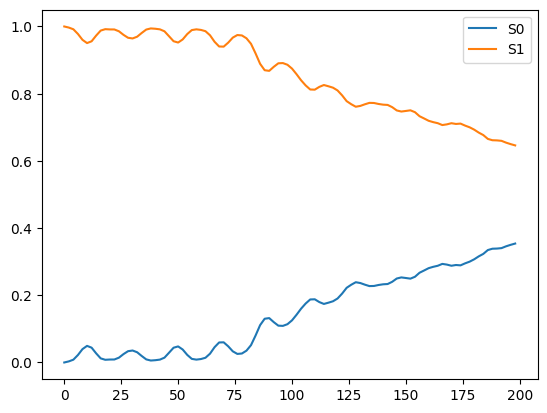

In [16]:
plt.plot(time_data, density_data_0[:, 0], label="S0")
plt.plot(time_data, density_data_0[:, 1], label="S1")
plt.legend()
plt.show()

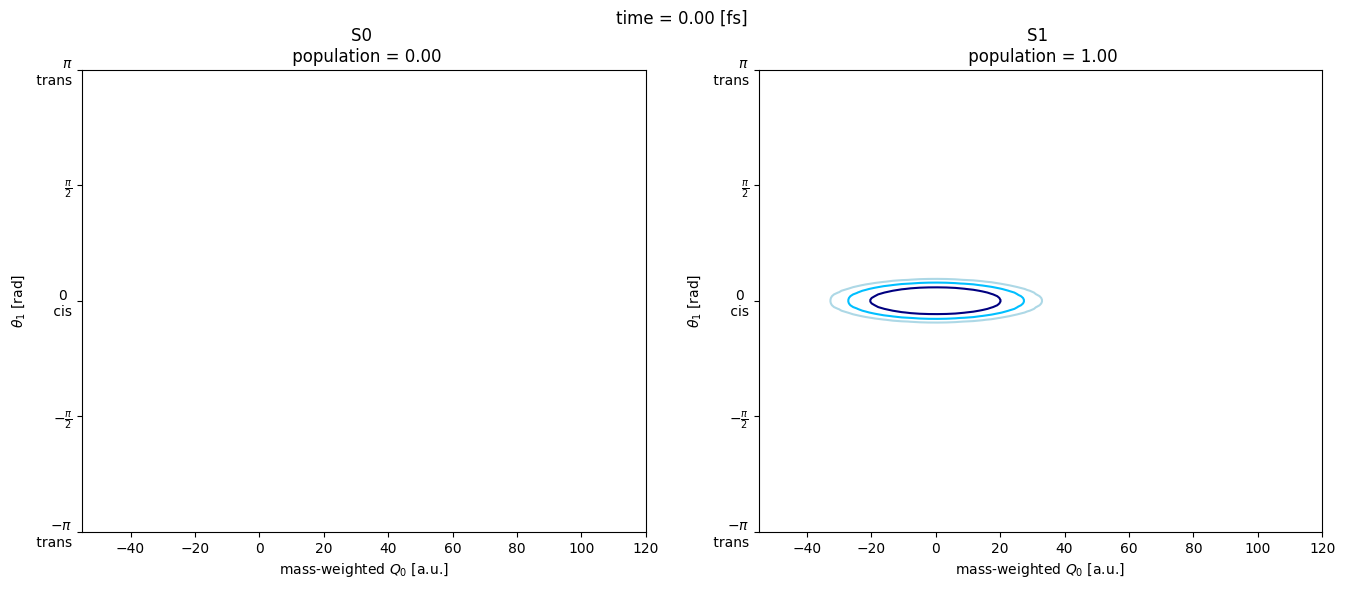

In [17]:
from matplotlib.animation import FuncAnimation

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 6))

Q, θ = np.meshgrid(basis[1].get_grids(), basis[2].get_grids())


def update(i):
    ax0.cla()
    ax1.cla()
    im0 = ax0.contour(
        Q,
        θ,
        density_data_012[i, 0, :, :].T,
        levels=[1.0e-05, 1.0e-04, 1.0e-03],
        colors=["lightblue", "deepskyblue", "navy"],
    )
    # cmap='jet', vmin=0, vmax=0.05, )
    im1 = ax1.contour(
        Q,
        θ,
        density_data_012[i, 1, :, :].T,
        levels=[1.0e-05, 1.0e-04, 1.0e-03],
        colors=["lightblue", "deepskyblue", "navy"],
    )
    # fix coordinate of title
    fig.suptitle(f"time = {time_data[i]:4.2f} [fs]")
    ax0.set_title(
        f"S0 \n population = {np.sum(density_data_012[i, 0, :, :]):0.2f}"
    )
    ax1.set_title(
        f"S1 \n population = {np.sum(density_data_012[i, 1, :, :]):0.2f}"
    )
    ax0.set_xlabel("mass-weighted $Q_0$ [a.u.]")
    ax1.set_xlabel("mass-weighted $Q_0$ [a.u.]")
    ax0.set_ylabel(r"$\theta_1$ [rad]")
    ax1.set_ylabel(r"$\theta_1$ [rad]")
    ax0.set_yticks(
        [-np.pi, -np.pi / 2.0, 0.0, np.pi / 2.0, np.pi],
        [
            "$-\\pi$ \n trans",
            r"$-\frac{\pi}{2}$",
            "0 \n cis",
            r"$\frac{\pi}{2}$",
            "$\\pi$ \n trans",
        ],
    )
    ax1.set_yticks(
        [-np.pi, -np.pi / 2.0, 0.0, np.pi / 2.0, np.pi],
        [
            "$-\\pi$ \n trans",
            r"$-\frac{\pi}{2}$",
            "0 \n cis",
            r"$\frac{\pi}{2}$",
            "$\\pi$ \n trans",
        ],
    )
    return im0, im1


anim = FuncAnimation(fig, update, frames=range(0, len(time_data)), interval=100)
if use_bath:
    gif_name = "reduced_density_exciton_bath.gif"
else:
    gif_name = "reduced_density_exciton_zerotemp.gif"
anim.save(gif_name, writer="pillow")